In [240]:
from IPython.display import HTML
from IPython.display import Image
Image(url= "https://media.licdn.com/dms/image/C4E0BAQG9gFcPay9CyQ/company-logo_200_200/0?e=2159024400&v=beta&t=8GwuSv3UaEo1XDh7REBn5f-ZMIKQJI9zCaeRWDBYAXg" )


## Importing Libraries

In [244]:
import json
import tweepy
import csv
import codecs

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

import time
import os

import pandas as pd
from pandas.io.json import json_normalize as jn

import re,string
import base64 
from scipy.misc import imread
import codecs

from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator

import matplotlib.pyplot as plt

twitter_cred = dict()

twitter_cred['CONSUMER_KEY'] = '17XHiftb4Iu5hVAIh4NacWj9S'
twitter_cred['CONSUMER_SECRET'] = '8xAXhFsfnkiFjSFO5THqRO5J8x8lKSzC9J2GNPUSY7ZPb5z6Qv'
twitter_cred['ACCESS_KEY'] = '1392379572-FInzXaziEqyNCGc8jqtU9LwnFFlHYRpjoihZpiX'
twitter_cred['ACCESS_SECRET'] = 'JBDveSiUU6aXpwx8QkxYhXloDr9DyHn7ocqrqgWqwqctw'

In [175]:
with open('twitter_credentials.json', 'w') as secret_info:
    json.dump(twitter_cred, secret_info, indent=4, sort_keys=True)
    

In [176]:
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

# Create the api endpoint

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

### Stream Listener for scrapping tweets

In [384]:

start_time = time.time()
class MyListener(StreamListener):
    def __init__(self, start_time, time_limit=60):
 
        self.time = start_time
        self.limit = time_limit
        self.tweet_data = []
        self.saveFile = open('raw_tweets.json', 'a', encoding='utf-8')
    
    def on_data(self, data):
        if (time.time() - self.time) < self.limit:
            try:
                self.tweet_data.append(data)
                saveFile = open('raw_tweets.json', 'w', encoding='utf-8')
                saveFile.write(u'[\n')
                saveFile.write(','.join(self.tweet_data))
                saveFile.write(u'\n]')
                saveFile.close()
                #exit()
                return True
            except BaseException as e:
                print("Error on_data: %s" % str(e))
                time.sleep(5)
                return True
        else:
            self.saveFile.close()
            return False 
                
 
        
    
    def on_error(self, status):
        print(status)
        return True


#if __name__ == '__main__':
    #MyListener = MyListener()
    #auth = OAuthHandler(consumer_key, consumer_secret)
    #auth.set_access_token(access_key, access_secret)
    #stream = Stream(auth,MyListener )
    #stream.filter(track=['#ML', '#Datascience', '#Arima'])



### Starting the Listener

In [385]:
#MyListener = MyListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
stream = Stream(auth,MyListener(start_time, time_limit=1723) )
stream.filter(track=['#ML', '#AI', '#deeplearning'])


### Making a Dataframe using the JSON file

In [386]:
# data=open('raw_tweets.json', 'r', encoding='utf-8')
# df = pandas.io.json.json_normalize(data)
# df.columns = df.columns.map(lambda x: x.split(".")[-1])
# df.head()

with open('raw_tweets.json', 'r', encoding="utf-8") as json_file:
    json_work = json.load(json_file)
    
df = pd.io.json.json_normalize(json_work)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Columns: 365 entries, contributors to user.verified
dtypes: bool(13), float64(71), int64(11), object(270)
memory usage: 2.7+ MB


In [387]:
#Setting our source for text generation
df_clean=df['text']


In [388]:
#Making the dataframe
df_cleans=pd.DataFrame({'text':df_clean})

### Functions for formatting of text and their outputs

In [389]:
def remove_RT(x):
    if x=="RT ":
        return " "
        #return str(x.replace('b\'RT ',''))

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    #cleanString   = re.sub('\W+','', string )
    for link in links:
        text = text.replace(link[0], ', ')    
        #text = text.replace(cleanString, '')
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

In [390]:
df_cleans['TextNoMentions']=df_cleans['text'].str.replace('RT', ' ')

In [391]:
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].str.replace('#', '', case=False)

In [392]:
#df_cleans['TextNoLinks']=df_cleans['text'].apply(strip_links)
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].str.replace('http\S+|www.\S+', '', case=False)

In [393]:
#df_cleans['TextNoEntities']=df_cleans['TextNoLinks'].apply(strip_all_entities)
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].apply(strip_all_entities)

In [394]:
df_cleans['TextNoMentions']=df_cleans['TextNoMentions'].apply(removeNonAscii)

In [395]:
a=df_cleans['TextNoMentions'].unique()

In [396]:
a=a.tolist()

In [397]:
df_cleaner=pd.DataFrame({'text':a})

In [398]:
df_cleaner.head()

,text
0,Exciting that is about to start dktech dkpol d...
1,vanLoon This Robot Can Makes Salads and Health...
2,This autonomousvehicle is an office restaurant...
3,The cloud amp AI go hand in hand says Deputy C...
4,Biometrics market to approach 52 billion by 20...


In [399]:
df_cleaner['text']=df_cleaner['text'].str.lower()

### The avg number of words in text 

In [400]:
# Lets check the avg number of words in text written by each author in a histogram 
def word_count(row):
    """function to calculate the count of words in a given text """
    text = row['text']
    text_splited = text.split(' ')
    word_count = text_splited.__len__()
    return word_count

df_cleaner['word_count'] = ''
df_cleaner['word_count'] = df_cleaner.apply(lambda row: word_count(row), axis =1)
df_cleaner.head()

,text,word_count
0,exciting that is about to start dktech dkpol d...,12
1,vanloon this robot can makes salads and health...,16
2,this autonomousvehicle is an office restaurant...,18
3,the cloud amp ai go hand in hand says deputy c...,17
4,biometrics market to approach 52 billion by 20...,15


### Generating Wordclouds

(-0.5, 399.5, 199.5, -0.5)

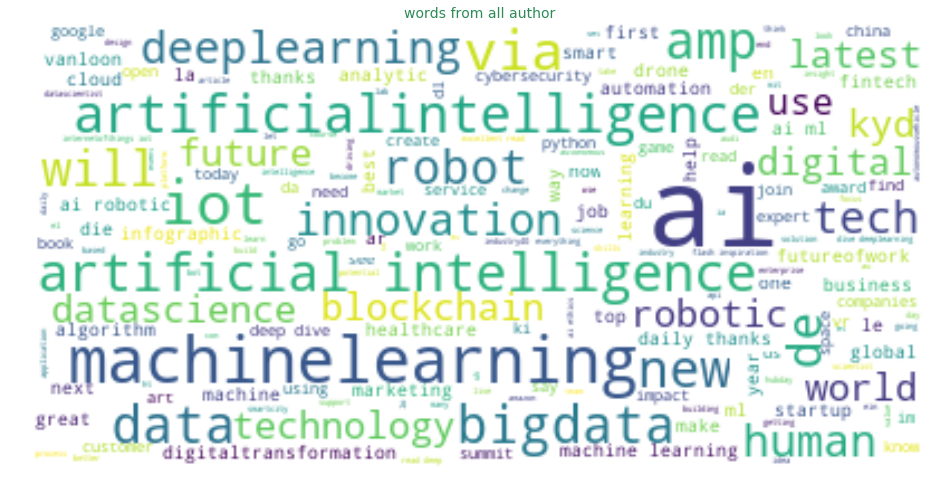

In [401]:
#mws = df_cleaner["text"].values

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)
# generate word cloud
wc.generate(" ".join(df_cleaner.text.values))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14,color='seagreen')
plt.axis("off")

In [402]:
def base_64(input_image):
    """ Function to convert the image to base64 """
    image = open(input_image, 'rb') #open binary file in read mode 
    image_read = image.read()
    output_base64 = base64.encodestring(image_read)
    return output_base64

In [403]:
def codecs_img(input_image,base64_image):
    """Generate the Mask for EAP """
    f1 = open(input_image, "wb")
    f1.write(codecs.decode(base64_image,'base64'))
    f1.close()
    img1 = imread(input_image)
    #img = img1.resize((980,1000))
    #imgplot=plt.imshow(img1)
    #plt.show()
    hcmask=img1
    return hcmask 

In [404]:
mask = base_64('mask.png')

/Users/manalisharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: encodestring() is a deprecated alias since 3.1, use encodebytes()
  """


In [405]:
hcmask1 = codecs_img('mask.png' , mask)

/Users/manalisharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [406]:
#STOPWORDS=STOPWORDS.add('gt')

In [407]:
mask = df_cleaner['text'].values

In [408]:
def generate_wordcloud(words, mask):
    """ Generating Word Clouds """
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=STOPWORDS, mask=mask, max_font_size= 45).generate(" ".join(words))
    plt.figure(figsize=(10,8))
    image_colors = ImageColorGenerator(mask)
    plt.imshow(word_cloud, interpolation='bilinear') # interpolation(helps in masking)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    

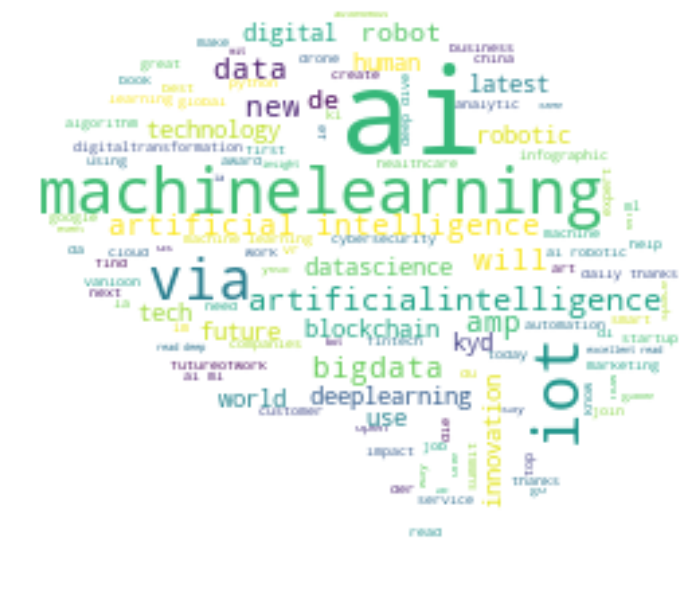

In [409]:
generate_wordcloud(mask,hcmask1)

### LSTM Data Modelling

In [410]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils


### Creating character/word mappings

In [411]:
import string
 
# turn a doc into clean tokens
def clean_doc(row):
    # replace '--' with a space ' '
    text = row['text']
    text = text.replace('--', ' ')
    # split into tokens by white space
    tokens = text.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens



In [412]:
df_cleaner['token'] = df_cleaner.apply(lambda row: clean_doc(row), axis =1)
#loaded document as an argument and returns an array of clean tokens.

In [413]:
df_cleaner.head()

,text,word_count,token
0,exciting that is about to start dktech dkpol d...,12,"[exciting, that, is, about, to, start, dktech,..."
1,vanloon this robot can makes salads and health...,16,"[vanloon, this, robot, can, makes, salads, and..."
2,this autonomousvehicle is an office restaurant...,18,"[this, autonomousvehicle, is, an, office, rest..."
3,the cloud amp ai go hand in hand says deputy c...,17,"[the, cloud, amp, ai, go, hand, in, hand, says..."
4,biometrics market to approach 52 billion by 20...,15,"[biometrics, market, to, approach, billion, by..."


### Creating a set of all words in the text columns

In [418]:
#creating a set of all words in the text columns
def list_creation(list_trial):
    list_trial=list_trial.tolist()
    result_trial = set(x for l in list_trial for x in l)
    #print (result_set)
    return (result_trial)   

In [430]:
df_tokens=list_creation(df_cleaner['token'])
df_tokens_=set(df_tokens)
print('Total Tokens: %d' % len(df_tokens))
print('Unique Tokens: %d' % len(df_tokens_)

SyntaxError: unexpected EOF while parsing (<ipython-input-430-2af7021625ce>, line 4)

### General idea , creating sequences

Organize the long list of tokens into sequences of n input words and 1 output word, That is, sequences of n+1 words. We can do this by iterating over the list of tokens from token n+1 onwards and taking the prior n tokens as a sequence, then repeating this process to the end of the list of tokens.



In [438]:
# organize into sequences of tokens
length = 11 + 1
sequences = list()
df_tokens=list(df_tokens)
for i in range(length, len(df_tokens)):
    # select sequence of tokens
    seq = df_tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
#use sequences for modeling

Total Sequences: 3125


The model we will train is a neural language model. It has a few unique characteristics:

It uses a distributed representation for words so that different words with similar meanings will have a similar representation. It learns the representation at the same time as learning the model. It learns to predict the probability for the next word using the context of the last 100 words. Specifically, we will use an Embedding Layer to learn the representation of words, and a Long Short-Term Memory (LSTM) recurrent neural network to learn to predict words based on their context.



### Save tokens to file, one dialog per line

In [439]:
# save tokens to file, one dialog per line

def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [440]:
out_filename = 'republic_sequences.txt'
save_doc(sequences, out_filename)

Encode Sequences
The word embedding layer expects input sequences to be comprised of integers.

We can map each word in our vocabulary to a unique integer and encode our input sequences. Later, when we make predictions, we can convert the prediction to numbers and look up their associated words in the same mapping.

To do this encoding, we will use the Tokenizer class in the Keras API.

First, the Tokenizer must be trained on the entire training dataset, which means it finds all of the unique words in the data and assigns each a unique integer.

We can then use the fit Tokenizer to encode all of the training sequences, converting each sequence from a list of words to a list of integers.

In [441]:
def load_doc(filename):
# open the file as read only
    file = open(filename, 'r')
# read all text
    text = file.read()
# close the file
    file.close()
    return text
 
# load
in_filename = 'republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')


### Integer encode sequences of words

In [442]:
from keras.preprocessing.text import Tokenizer
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

We can access the mapping of words to integers as a dictionary attribute called word_index on the Tokenizer object.

In [443]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1


In [444]:
import numpy as np
sequences = np.asarray(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
seq_length = X.shape[1]

In [445]:
y = np_utils.to_categorical(y, num_classes=vocab_size)

### Define model

In [446]:
# define model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 11, 50)            156850    
_________________________________________________________________
lstm_13 (LSTM)               (None, 11, 100)           60400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 3137)              316837    
Total params: 624,587
Trainable params: 624,587
Non-trainable params: 0
_________________________________________________________________
None


In [447]:
%%capture
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
MODEL=model.fit(X, y, batch_size=128, epochs=100)


In [454]:
# save the model to file
from json import dumps, loads
model.save('model.h5')
# save the tokenizer
import pickle
output = open('myfile.pkl', 'wb')
pickle.dump(tokenizer, output)
output.close()




In [455]:
#Use Language Model
#in_filename = 'republic_sequences.txt'
#doc = load_doc(in_filename)
#lines = doc.split('\n')

In [456]:
#pkl_file = open('tokenizer.pkl', 'rb')
#mydict2 = pickle.load(pkl_file)
#pkl_file.close()
seq_length = len(lines[0].split()) - 1

In [457]:
from random import randint
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

smith supermarket bills growth artifi ki disease helped consists months daimler countrys



In [458]:
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
    # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
    # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
    # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
    # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
    # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [459]:
from keras.preprocessing.sequence import pad_sequences
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

biggest jeff hour event might cars philosophy analysis hybrid flyingcars valeo orchestrate packed vielen real available president stars gebied anticipated inteligenciaartificial unemployment kitchen eye thrones activities schwchen wollen lata pursuing war encore internal thats h ago emerged milan says segunda mquinas earbuds bollmoor hospitals page talentacquisition convergenttechnologies supplychain conceived diy


In [59]:
# characters = sorted(list(set(df_cleaner['text'])))
# n_to_char = {n:char for n, char in enumerate(characters)}
# char_to_n = {char:n for n, char in enumerate(characters)}
# #All unique characters are first stored in characters and are then enumerated.
# #However, when compared with each other, a word-based model shows much higher accuracy as compared to a 
# #character-based model. This is because the latter model requires a much larger network to learn 
# #long-term dependencies as it not only has to remember the sequences of words, 
# #but also has to learn to predict a grammatically correct word. However, in case of a word-based model, 
# #the latter has already been taken care of.

In [255]:
df_cleans.head()
df_cleans.to_csv("new.csv", index=False)